2.4.0
                                                text
0  [ king henry iv ] so shaken as we are, so wan ...
1  [ westmoreland ] my liege, this haste was hot ...
2  [ king henry iv ] it seems then that the tidin...
3  [ westmoreland ] this match'd with other did, ...
4  [ king henry iv ] here is a dear, a true indus...


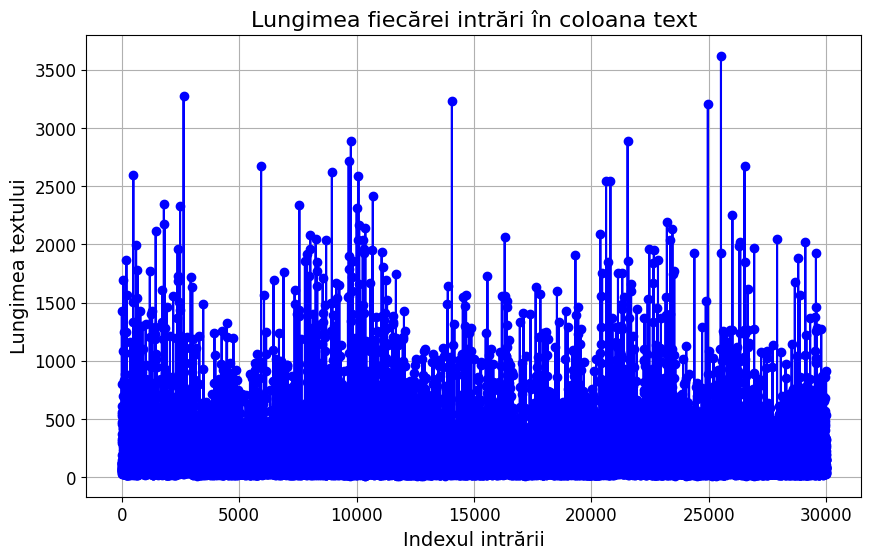

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

file_path = "/kaggle/input/shake-lines/merged_shakespeare_lines.csv"
data = pd.read_csv(file_path)

print(data.head())

data['text_length'] = data['text'].apply(len)

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['text_length'], marker='o', linestyle='-', color='b')
plt.title('Lungimea fiecărei intrări în coloana text', fontsize=16)
plt.xlabel('Indexul intrării', fontsize=14)
plt.ylabel('Lungimea textului', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [2]:
from transformers import GPT2Tokenizer
from typing import List

class SubTok:
    def __init__(self, pretrained_model_name='gpt2', special_tokens=None):
        self.tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name)
        
        if special_tokens is None:
            special_tokens = ["<SOS>", "<EOS>", "<PAD>"]
        
        self.tokenizer.add_tokens(special_tokens)
        self.vocab_size = self.tokenizer.vocab_size;

        self.pad_token = special_tokens[2]
        self.sos_token = special_tokens[0]
        self.eos_token = special_tokens[1]
        self.pad_token_id = self.convert_tokens_to_ids([self.pad_token])[0]

    def tokenize(self, text: str) -> List[str]:
        tokens = [self.sos_token] + self.tokenizer.tokenize(text) + [self.eos_token]
        return tokens

    def convert_tokens_to_ids(self, tokens: List[str]) -> List[int]:
        return self.tokenizer.convert_tokens_to_ids(tokens)

    def convert_ids_to_tokens(self, ids: List[int]) -> List[str]:
        return self.tokenizer.convert_ids_to_tokens(ids)

    def detokenize(self, tokens: List[str]) -> str:
        tokens = [token for token in tokens if token not in [self.sos_token, self.eos_token]]
        return self.tokenizer.convert_tokens_to_string(tokens)

    def decode(self, ids: List[int]) -> str:
        tokens = self.convert_ids_to_tokens(ids)
        return self.detokenize(tokens)


tokenizer = SubTok()
print(tokenizer.pad_token, tokenizer.pad_token_id)
text = "Anne, has apples."
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", ids)
reconstructed_tokens = tokenizer.convert_ids_to_tokens(ids)
print("Reconstructed Tokens:", reconstructed_tokens)
reconstructed_text = tokenizer.detokenize(reconstructed_tokens)
print("Reconstructed Text:", reconstructed_text)
reconstructed_text_via_decode = tokenizer.decode(ids)
print("Reconstructed Text via Decode:", reconstructed_text_via_decode)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

<PAD> 50259
Tokens: ['<SOS>', 'Anne', ',', 'Ġhas', 'Ġapples', '.', '<EOS>']
Token IDs: [50257, 43227, 11, 468, 22514, 13, 50258]
Reconstructed Tokens: ['<SOS>', 'Anne', ',', 'Ġhas', 'Ġapples', '.', '<EOS>']
Reconstructed Text: Anne, has apples.
Reconstructed Text via Decode: Anne, has apples.


In [3]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        out = self.embed(x)
        return out

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, embed_model_dim):
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim
        self.max_seq_len = max_seq_len

        pe = torch.zeros(max_seq_len, self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / self.embed_dim)))
                if i + 1 < self.embed_dim:
                    pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.embed_dim)
        seq_len = x.size(1)
    
        if seq_len > self.pe.size(1):
            extra_pe = torch.zeros(1, seq_len - self.pe.size(1), self.embed_dim).to(x.device)
            for pos in range(self.pe.size(1), seq_len):
                for i in range(0, self.embed_dim, 2):
                    extra_pe[0, pos - self.pe.size(1), i] = math.sin(pos / (10000 ** ((2 * i) / self.embed_dim)))
                    if i + 1 < self.embed_dim:
                        extra_pe[0, pos - self.pe.size(1), i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / self.embed_dim)))
            self.pe = torch.cat([self.pe, extra_pe], dim=1)
        
        x = x + self.pe[:, :seq_len].to(x.device)
        return x

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.single_head_dim = int(self.embed_dim / self.n_heads)

        self.W_Q = nn.Parameter(torch.randn(self.embed_dim, self.embed_dim))
        self.W_K = nn.Parameter(torch.randn(self.embed_dim, self.embed_dim))
        self.W_V = nn.Parameter(torch.randn(self.embed_dim, self.embed_dim))
        self.W_O = nn.Parameter(torch.randn(self.embed_dim, self.embed_dim))

    def forward(self,key,query,value):
        batch_size, seq_length, _ = key.size()
        seq_length_query = query.size(1)

        Q = torch.matmul(query, self.W_Q)
        K = torch.matmul(key, self.W_K)
        V = torch.matmul(value, self.W_V)

        Q = Q.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.n_heads, self.single_head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.n_heads, self.single_head_dim).transpose(1, 2)

        K_T = K.transpose(-1, -2)
        product = torch.matmul(Q, K_T)

        mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(product.device)
        mask = mask.unsqueeze(0).unsqueeze(0).expand(batch_size, self.n_heads, -1, -1)
        product = product.masked_fill(mask, float('-inf'))

        product = product / torch.sqrt(torch.tensor(self.single_head_dim, dtype=torch.float32))

        scores = F.softmax(product, dim=-1)
        scores = torch.matmul(scores, V)

        output = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.embed_dim)
        output = torch.matmul(output, self.W_O)
        return output

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, embed_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(embed_dim))
        self.beta = nn.Parameter(torch.zeros(embed_dim))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x_norm = (x - mean) / (std + self.eps)
        return self.gamma * x_norm + self.beta

In [7]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Parameter(torch.randn(embed_dim, hidden_dim))
        self.linear2 = nn.Parameter(torch.randn(hidden_dim, embed_dim))
        self.bias1 = nn.Parameter(torch.zeros(hidden_dim))
        self.bias2 = nn.Parameter(torch.zeros(embed_dim))

    def forward(self, x):
        hidden = F.relu(torch.matmul(x, self.linear1) + self.bias1)
        output = torch.matmul(hidden, self.linear2) + self.bias2
        return output

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads, hidden_dim):
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = LayerNorm(embed_dim)
        self.layer_norm2 = LayerNorm(embed_dim)
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        self.feed_forward = FeedForward(embed_dim, hidden_dim)

    def forward(self, x):
        attn_input = self.layer_norm1(x)
        attn_output = self.attention(attn_input, attn_input, attn_input)
        x = x + attn_output
        ff_input = self.layer_norm2(x)
        ff_output = self.feed_forward(ff_input)
        x = x + ff_output

        return x

In [9]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, max_seq_len, embed_dim=512, n_heads=8, n_layers=6, hidden_dim=2048):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_embedding = PositionalEmbedding(max_seq_len, embed_dim)
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_dim, n_heads, hidden_dim) for _ in range(n_layers)]
        )
        self.output_projection = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_embedding(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.output_projection(x)
        return logits

In [10]:
from sklearn.model_selection import train_test_split

tokenizer = SubTok()
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

print(len(train_data), len(test_data))

train_data['tokens'] = train_data['text'].apply(lambda x: tokenizer.tokenize(x))
train_data['token_ids'] = train_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

test_data['tokens'] = test_data['text'].apply(lambda x: tokenizer.tokenize(x))
test_data['token_ids'] = test_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

def prepare_inputs_outputs(token_ids):
    input_ids = token_ids[:-1]
    output_ids = token_ids[1:]
    return input_ids, output_ids

train_data['input_output'] = train_data['token_ids'].apply(prepare_inputs_outputs)
train_data['input_ids'] = train_data['input_output'].apply(lambda x: x[0])
train_data['output_ids'] = train_data['input_output'].apply(lambda x: x[1])

test_data['input_output'] = test_data['token_ids'].apply(prepare_inputs_outputs)
test_data['input_ids'] = test_data['input_output'].apply(lambda x: x[0])
test_data['output_ids'] = test_data['input_output'].apply(lambda x: x[1])

train_data.drop(columns=['input_output'], inplace=True)
test_data.drop(columns=['input_output'], inplace=True)

print(train_data[['text', 'tokens', 'input_ids', 'output_ids']].head())

26997 3000
                                                    text  \
346            [ bardolph ] what think you they portend?   
13028  [ gloucester ] come, come, away. exeunt all bu...   
8821   [ lord polonius ] you know, sometimes he walks...   
25676  [ timon ] if thou hatest curses, stay not, fly...   
7534   [ coriolanus ] wife, mother, child, i know not...   

                                                  tokens  \
346    [<SOS>, [, Ġb, ard, olph, Ġ], Ġwhat, Ġthink, Ġ...   
13028  [<SOS>, [, Ġgl, ou, cester, Ġ], Ġcome, ,, Ġcom...   
8821   [<SOS>, [, Ġlord, Ġpol, on, ius, Ġ], Ġyou, Ġkn...   
25676  [<SOS>, [, Ġtim, on, Ġ], Ġif, Ġthou, Ġhat, est...   
7534   [<SOS>, [, Ġcor, iol, anus, Ġ], Ġwife, ,, Ġmot...   

                                               input_ids  \
346    [50257, 58, 275, 446, 10196, 2361, 644, 892, 3...   
13028  [50257, 58, 1278, 280, 33187, 2361, 1282, 11, ...   
8821   [50257, 58, 15876, 755, 261, 3754, 2361, 345, ...   
25676  [50257, 58, 4628, 26

In [11]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

def pad_sequences(sequences, max_len, pad_token="<PAD>"):
    padded_sequences = []
    pad_id = tokenizer.tokenizer.get_vocab().get(pad_token, None)

    if pad_id is None:
        raise ValueError("Padding token not found!")

    for seq in sequences:
        seq = seq.tolist() if isinstance(seq, torch.Tensor) else seq

        if len(seq) < max_len:
            padded_seq = seq + [pad_id] * (max_len - len(seq))
        else:
            padded_seq = seq[:max_len]

        padded_sequences.append(torch.tensor(padded_seq, dtype=torch.long))

    return padded_sequences

class ShakespeareDataset(Dataset):
    def __init__(self, data, max_seq_len):
        self.data = data
        self.max_seq_len = max_seq_len
        self.pad_token = "<PAD>"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = self.data.iloc[idx]['input_ids']
        output_ids = self.data.iloc[idx]['output_ids']

        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(output_ids, dtype=torch.long)

def collate_fn(batch):
    max_len = 512
    input_batch = [pad_sequences([item[0]], max_len)[0] for item in batch]
    output_batch = [pad_sequences([item[1]], max_len)[0] for item in batch]
    
    input_tensor = torch.stack([torch.tensor(seq, dtype=torch.long) for seq in input_batch])
    output_tensor = torch.stack([torch.tensor(seq, dtype=torch.long) for seq in output_batch])
    return input_tensor, output_tensor

batch_size = 16
max_seq_len = 512
train_dataset = ShakespeareDataset(train_data, max_seq_len)
test_dataset = ShakespeareDataset(test_data, max_seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

vocab_size = tokenizer.vocab_size + 3
print(vocab_size)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TransformerDecoder(
    vocab_size=vocab_size,  
    max_seq_len=max_seq_len,
    embed_dim=128,          
    n_heads=2,    
    n_layers=2,             
    hidden_dim=128
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

50260


In [12]:
import torch
from torch.nn.functional import cross_entropy
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def logits_to_predictions(logits, tokenizer, pad_token_id=None):
    probabilities = torch.softmax(logits.float(), dim=-1)
    predicted_ids = torch.argmax(probabilities, dim=-1)

    predictions = []
    for seq_ids in predicted_ids:
        tokens = tokenizer.convert_ids_to_tokens(seq_ids.tolist())
        text = tokenizer.detokenize(tokens)
        if pad_token_id is not None:
            text = text.replace(tokenizer.pad_token, '').strip()

        predictions.append(text)
    return predictions

def calculate_perplexity_blue(model, dataloader, criterion, tokenizer):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    bleu_scores = []
    smooth_fn = SmoothingFunction().method1
    
    with torch.no_grad():
        for input_ids, target_ids in dataloader:
            input_ids = input_ids.to("cuda")
            target_ids = target_ids.to("cuda")

            valid_tokens = (target_ids != tokenizer.pad_token_id).to(torch.bool)
            
            logits = model(input_ids)
            predictions = logits_to_predictions(logits, tokenizer, pad_token_id=tokenizer.pad_token_id)
            refs = logits_to_predictions(target_ids, tokenizer, pad_token_id=tokenizer.pad_token_id)
            
            shift_logits = logits[:, :-1].contiguous()
            shift_labels = target_ids[:, 1:].contiguous()

            loss = criterion(shift_logits.view(-1, shift_logits.size(-1)),shift_labels.view(-1))
            
            total_loss += loss.item() * valid_tokens.sum().item()
            total_tokens += valid_tokens.sum().item()

            for pred, ref in zip(predictions, refs):
                ref_tokens = ref.split()
                pred_tokens = pred.split()
                bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth_fn)
                bleu_scores.append(bleu)
                
    perplexity = torch.exp(torch.tensor(total_loss / total_tokens))
    # print(bleu_scores, "blue_scores")
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0

    return perplexity, avg_bleu_score

def predict_example(model, tokenizer, train_loader):
    text = data.iloc[1]['text']
    tokens = tokenizer.tokenize(text)
    
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_tensor = torch.tensor([input_ids]).to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
    
    predicted_ids = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_ids)
    
    predicted_text = tokenizer.detokenize(predicted_tokens)
    print("Predicted Text:", predicted_text)

In [13]:
import math

epochs = 60
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for input_ids, output_ids in train_loader:
        input_ids, output_ids = input_ids.to(device), output_ids.to(device)
        optimizer.zero_grad()

        logits = model(input_ids)

        loss = criterion(logits.view(-1, vocab_size), output_ids.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    predict_example(model, tokenizer, train_loader)
    perplexity, blue_score = calculate_perplexity_blue(model, test_loader, criterion, tokenizer)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}, BlueScore: {blue_score:.4f}")

Predicted Text: [ king citizen ]<PAD> your bindge of sirvirFortunately reg<PAD> with make child sure<PAD><PAD> wife farewell<PAD>ont<PAD> dile<PAD> shatteringcomponent do,, '<PAD>,<PAD> the let knight mineTheme poor is, abusing,ched<PAD>rix bearsched corruples do given couldru<PAD> mine to<PAD> prosperous charge of Previewru been voice rather<PAD><PAD> given bears norruarium fabricunn cor waive a this common given the<PAD> attend<PAD>ves run<PAD>: given wretched<PAD>pload play reven vel gift given vel the-un Vaughan given iל waive her thy to cry<PAD> very'll iseness moth surereenshot my resurg a,
Epoch 1/60, Loss: 47.9434, Perplexity: 112247873536.0000, BlueScore: 0.0001
Predicted Text: [ i citizenissa<PAD> sa bindge. then company or i<PAD> with make then, them<PAD> wife farewell<PAD>ont<PAD> prog<PAD> you will had,, '<PAD> you thee beg: had quTheme, guilt, abusing thee termsgerix w terms'd thisples do one given master this<PAD> scene to<PAD> toers devised Preview this weary voiceou. t

In [14]:
import os

output_dir = '/kaggle/working/output'
os.makedirs(output_dir, exist_ok=True)

model_save_path = os.path.join(output_dir, 'transformer_decoder_model2.pt')
torch.save(model.state_dict(), model_save_path)

print(f"Modelul a fost salvat în {model_save_path}")

Modelul a fost salvat în /kaggle/working/output/transformer_decoder_model2.pt
